In [1]:
import os
import sys
import random
import numpy as np
import optuna
import joblib
from importlib import reload  # Import the reload function
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import utils.helpers as hp
import utils.preprocess as pp
import utils.modeling as md  

reload(hp)
reload(pp)
reload(md)
%load_ext autoreload
%autoreload 1

/home/jonas/Projects/CryptoModeler/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-06 21:16:33.243709: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736223393.344072  463443 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736223393.396879  463443 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 21:16:33.556328: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performa

In [62]:
samples = 445773


shift = 20
epics = 50
window = 3000
roller = samples / shift / epics

(samples - window) / roller


993.2701173018554

In [63]:
3000/20

150.0

In [2]:

timeframe_filenames = {
    "1m": "../data/raw/ETHUSDT_1m_v600k.csv",
    "3m": "../data/DOGEUSDT_3m_v0.csv",
    "5m": "../data/DOGEUSDT_5m_v0.csv",
    "15m": "../data/DOGEUSDT_15m_v0.csv",
    "30m": "../data/DOGEUSDT_30m_v0.csv"
}

def load_model_test_split(filenames, params, model_data_ratio=0.8):
    # Load data
    df = hp.load_data(filenames[params['timeframe']])
    # Create indicators
    indicated_df = pp.create_indicators(df, params['num_indicators'])
    
    # Split data
    model_df = indicated_df[:int(len(indicated_df)*model_data_ratio)]
    test_df = indicated_df[int(len(indicated_df)*model_data_ratio):]
    
    return model_df, test_df

def test_data(df, params):

    # Testing data
    test_df = pp.normalize_X(df, scaler_name=params['scaler_type'])

    # Testing data special treatment
    norm_X_test, y_test = pp.create_targets(test_df, params['window_size'], params['look_ahead_size'], params['look_ahead_size'])
    norm_y_test = pp.normalize_y(y_test)
    
    joblib.dump(norm_X_test, '../data/processed/X_normTest.pkl')
    joblib.dump(norm_y_test, '../data/processed/y_normTest.pkl')
    joblib.dump(y_test, '../data/processed/y_realTest.pkl')
    print('Test data dumped')
    return norm_X_test, norm_y_test

def custom_model(df, params, tuning=False, trial=None):

    # Load data and create indicators
    model_df = pp.normalize_X(df, scaler_name=params['scaler_type'])
    X_train, y_train = pp.create_targets(model_df, params['window_size'], params['look_ahead_size'], params['look_ahead_size'])
    
    y_train, scaler_y = pp.normalize_y(y_train, return_scaler=True)
    joblib.dump(scaler_y, '../data/processed/scaler_y.pkl')

    # Train
    model = md.train(X_train, y_train, params, epochs=50, train_size=3000, val_size=500, step_size=200, tuning=tuning, trial=trial) 
    
    return model

In [65]:
params = {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.005326718162056909, 'batch_size': 32, 'dense_units': 16, 'sequence_length': 10, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'tanh', 'num_indicators': 16, 'scaler_type': 'MinMaxScaler', 'timeframe': '1m', 'window_size': 80, 'look_ahead_size': 20}

model_df, test_df = load_model_test_split(timeframe_filenames, params)
model = custom_model(model_df, params)

Dataset loaded from ../data/raw/ETHUSDT_1m_v600k.csv.
(445773, 17) (111444, 17)
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1001 - mae: 0.1784 - val_loss: 0.0019 - val_mae: 0.0312
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0036 - mae: 0.0435 - val_loss: 0.0018 - val_mae: 0.0304
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0035 - mae: 0.0404 - val_loss: 0.0019 - val_mae: 0.0317
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0036 - mae: 0.0416 - val_loss: 0.0045 - val_mae: 0.0557
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0030 - mae: 0.0393 - val_loss: 0.0019 - val_mae: 0.0367
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0030 - mae: 0.0373 - val_loss: 0.0015 - val_mae: 0.0303
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0027 - mae: 0.0357 - val_loss: 0.0017 - val_mae: 0.0322
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0026 - mae: 0.0353 - val_loss: 0.0024 - val_mae: 0.0363
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0026

In [66]:
hp.save_model(model, '../models/model_1m_eth_v0.keras')

Model saved to ../models/model_1m_eth_v0.keras


In [67]:
import joblib

X_test, y_test = test_data(test_df, params)
# Save the test data

test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {test_loss}, Test MAE: {test_mae}')

Test data dumped
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0340 - mae: 0.1303
Test loss: 0.03963527828454971, Test MAE: 0.14020584523677826


174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


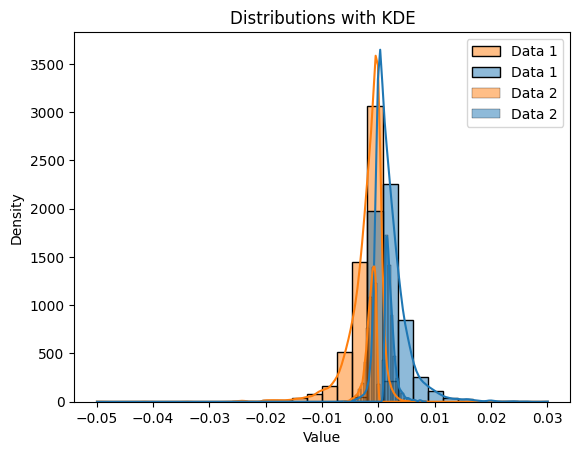

In [75]:
scaler_y = joblib.load('../data/processed/scaler_y.pkl')
y_real = joblib.load('../data/processed/y_realTest.pkl')
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
hp.distribution_plot(y_real,y_pred, colors=['blue', 'blue', 'red', 'red'])


In [3]:
# Objective function for optimization
def objective(trial):

    # MODEL CREATION
    params = {
        # LSTM Units
        "lstm_units_1": trial.suggest_categorical("lstm_units_1", [64, 128, 256]),
        "lstm_units_2": trial.suggest_categorical("lstm_units_2", [32, 64, 128]),

        # Dropout rate for regularization
        "dropout": trial.suggest_categorical("dropout", [0.1, 0.2, 0.3, 0.5]),

        # Learning rate for the optimizer (log scale for better range)
        "learning_rate": trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),

        # Batch size (common choices)
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),

        # Dense layer units (for fully connected layers after LSTM)
        "dense_units": trial.suggest_categorical("dense_units", [16, 32, 64, 128]),

        # Sequence length (historical data considered for prediction)
        "sequence_length": trial.suggest_categorical("sequence_length", [10, 20, 50, 100]),

        # Gradient clipping for preventing exploding gradients
        "gradient_clipping": trial.suggest_categorical("gradient_clipping", [0.5, 1.0, 2.0]),

        # Optimizer choice (Adam or RMSprop)
        "optimizer": trial.suggest_categorical("optimizer", ['adam', 'rmsprop']),

        # Activation function for layers
        "activation": trial.suggest_categorical("activation", ['relu', 'tanh']),

        "num_indicators" : trial.suggest_int('num_indicators', 5, 46),

        "scaler_type" : trial.suggest_categorical('scaler', ['MinMaxScaler', 'StandardScaler', 'RobustScaler']),
 
        'timeframe': '1m', 
        'window_size': 80, 
        'look_ahead_size': 20
    }

    # DATA CREATION AND PROCESSING
    timeframe_filenames = {
    "1m": "../data/raw/ETHUSDT_1m_v600k.csv",
    "3m": "../data/raw/DOGEUSDT_3m_v0.csv",
    "5m": "../data/raw/DOGEUSDT_5m_v0.csv",
    "15m": "../data/raw/DOGEUSDT_15m_v0.csv",
    "30m": "../data/raw/DOGEUSDT_30m_v0.csv"
}

    model_df, test_df = load_model_test_split(timeframe_filenames, params)

    print(params)
    model = custom_model(model_df, params, tuning=True, trial=trial)

    # Check if the trial is pruned after training
    if trial.should_prune():
        print("Trial pruned after training.")
        raise optuna.exceptions.TrialPruned()
    
    X_test, y_test = test_data(test_df, params)
    
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
    
    return test_mae 
    

In [ ]:

storage_path = "sqlite:///../optuna/study.db"
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)

#optuna.delete_study(study_name="the_study", storage=storage_path)
#study = optuna.create_study(storage=storage_path, study_name="the_study", direction='minimize', pruner=pruner)

study = optuna.load_study(storage=storage_path, study_name="the_study")

study.optimize(objective, n_trials=100)  # Run 100 trials


# Get the best parameters
print("Best parameters:", study.best_params)


Dataset loaded from ../data/raw/ETHUSDT_1m_v600k.csv.
{'lstm_units_1': 256, 'lstm_units_2': 32, 'dropout': 0.3, 'learning_rate': 0.00038625163133958684, 'batch_size': 128, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'relu', 'num_indicators': 34, 'scaler_type': 'MinMaxScaler', 'timeframe': '1m', 'window_size': 80, 'look_ahead_size': 20}


I0000 00:00:1736223426.619844  463443 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 164 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1
